**Note:** To be run in the same folder with the forked DGP library (CDML).

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from dgp.src.data_generation_configs import CausalGraphConfig, DataGenerationConfig, FunctionConfig, NoiseConfig, RuntimeConfig
from dgp.src.time_series_generator import TimeSeriesGenerator

import os 

import networkx as nx
import pickle 
import json 

### Get started

In [6]:
# Set general attributes.
complexity = 30

# Set attributes for causal graph. More are set directly in the configuration below.
min_lag = 1
max_lag = 1
num_targets = 1
num_features = 3
num_latent = 0 
max_target_parents = 3
max_target_children = 0

# Set attributes for data generation.
num_samples = 1000

# complexity is only used to initialise any unprovided configs. Here they are all initialised so it is ignored.
config = DataGenerationConfig(random_seed=1, complexity=complexity, percent_missing=0.0,
                                  causal_graph_config=CausalGraphConfig(
                                      graph_complexity=complexity,
                                      include_noise=True,
                                      max_lag=max_lag,
                                      min_lag=min_lag,
                                      num_targets=num_targets,
                                      num_features=num_features,
                                      num_latent=num_latent,
                                      prob_edge=0.8,
                                      max_parents_per_variable=1,
                                      max_target_parents=max_target_parents, max_target_children=max_target_children,
                                      max_feature_parents=3, max_feature_children=2,
                                      max_latent_parents=2, max_latent_children=2,
                                      allow_latent_direct_target_cause=False,
                                      allow_target_direct_target_cause=False,
                                      prob_target_autoregressive=0.0,
                                      prob_feature_autoregressive=0.0,
                                      prob_latent_autoregressive=0.0,
                                      prob_noise_autoregressive=0.0,
                                  ),
                                  noise_config=NoiseConfig(
                                      noise_complexity=complexity,
                                      noise_variance=[0.01, 0.1]
                                  ),
                                  runtime_config=RuntimeConfig(
                                      num_samples=num_samples, data_generating_seed=42
                                  )
                                  )

# Instantiate a time series generator.
ts_generator = TimeSeriesGenerator(config=config)

# Query for the completed config now that causal graph and SCM have been created.
full_config_dict = ts_generator.get_full_config()

# Generate data sets from this configuration.
data = ts_generator.generate_datasets()
datasets, causal_graph = data

DATA_NAME = f'Complexity {complexity} Num Features {num_features} Num Latent {num_latent} Max Lag {max_lag} Min Lag {min_lag} Target Max Parents {max_target_parents} Max Children {max_target_children} Samples {num_samples} Noise {config.noise_config.noise_variance[0]} {config.noise_config.noise_variance[1]}'
print(f'Generated dataset {DATA_NAME} \n')

df = datasets[0]  # We only generated one data set so just look at the first (and only) DataFrame.

print(df)

# Save the dataset to a csv file
DATA_DIR = 'datasets'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
df.to_csv(f'{DATA_DIR}/{DATA_NAME}.csv', index=False)

print(f'Saved dataset to {DATA_DIR}/{DATA_NAME}.csv')

Generated dataset Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1 

            X1        X2        X3        Y1
2    -0.812489 -0.192600  0.273402  0.387892
3     0.157786  0.293037  0.105014  0.408150
4    -0.388606  0.164679  0.006323  0.036488
5    -0.342579 -0.214095 -0.387978  0.275473
6    -0.712830  0.339074 -0.117714 -0.015677
...        ...       ...       ...       ...
997  -0.617760  0.281095 -0.361565 -0.114503
998  -0.950191  0.073343  0.178768  0.418774
999  -0.512294  0.015122 -0.471763  0.656462
1000 -0.754326  0.631936 -0.012310  0.363056
1001 -0.836694 -0.281216 -0.555058  0.341952

[1000 rows x 4 columns]
Saved dataset to datasets/Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1.csv


### Plot the time-series ground truth causal graph in nx DiGraph format

In [17]:
def plot_cdml(G: nx.DiGraph, target="Y"):
    """ 
    According to: https://github.com/causalens/cdml-neurips2020/blob/main/dgp/src/time_series_causal_graph.py, 
    but for NetworkX DiGraphs.
    
    Args: 
        - G (nx.DiGraph): the graph in NetworkX DiGraph format.
        - target (str): the target name, as in the unique variables (i.e., not time-lagged)
    """
    unique_variables = list(set([x.split('_t')[0] for x in G.nodes]))
    max_lag = max([int(x.split(':')[-1]) for x in G.nodes if '-' in x])

    x_positions = np.linspace(1.0, 0.0, max_lag + 1)
    y_positions = np.linspace(1.0, 0.0, len(unique_variables))

    # # Default color map for CDML format
    # color_map = {'Y': 0.0, 'X': 0.33, 'U': 0.67, 'S': 1.0}

    node_list = G.nodes
    edge_list = G.edges

    color_vals = [0.0 if node.startswith(target) else 0.33 for node in node_list]

    display_order = sorted([node for node in node_list if node.startswith(target)]) + \
        sorted([node for node in node_list if not node.startswith(target)])

    # Set (x,y) positions for each node.
    positions = dict(zip(display_order, [np.array([x, y]) for y in y_positions for x in x_positions]))

    plt.figure()
    nx.draw(G, pos=positions, with_labels=True, nodelist=node_list, edgelist=edge_list,
                    node_size=550, font_size=8, node_color=color_vals, cmap=plt.get_cmap('Set2'),
                    labels={node: node for node in display_order})
    plt.show()

### Visualization and saving

,X1,X2,X3,Y1
2,-0.812489,-0.192600,0.273402,0.387892
3,0.157786,0.293037,0.105014,0.408150
4,-0.388606,0.164679,0.006323,0.036488
5,-0.342579,-0.214095,-0.387978,0.275473
6,-0.712830,0.339074,-0.117714,-0.015677
...,...,...,...,...
997,-0.617760,0.281095,-0.361565,-0.114503
998,-0.950191,0.073343,0.178768,0.418774
999,-0.512294,0.015122,-0.471763,0.656462
1000,-0.754326,0.631936,-0.012310,0.363056


<class 'networkx.classes.digraph.DiGraph'>
Saved graph to datasets/Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1.png


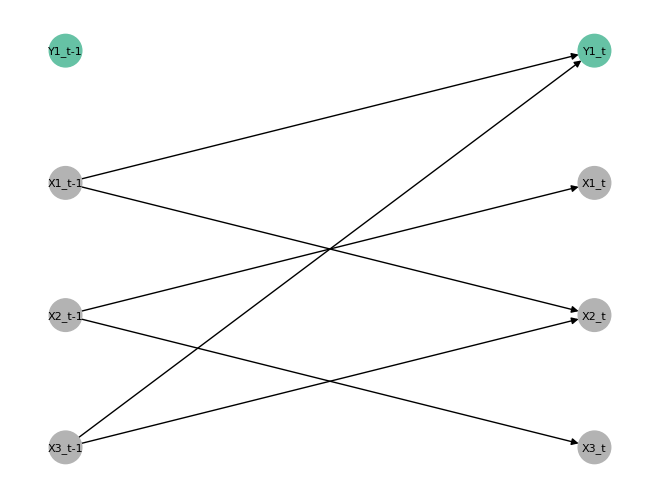

Saved pickled causal graph to datasets/Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1-causal_graph.pkl
Saved graph to datasets/Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1-summary_graph.png


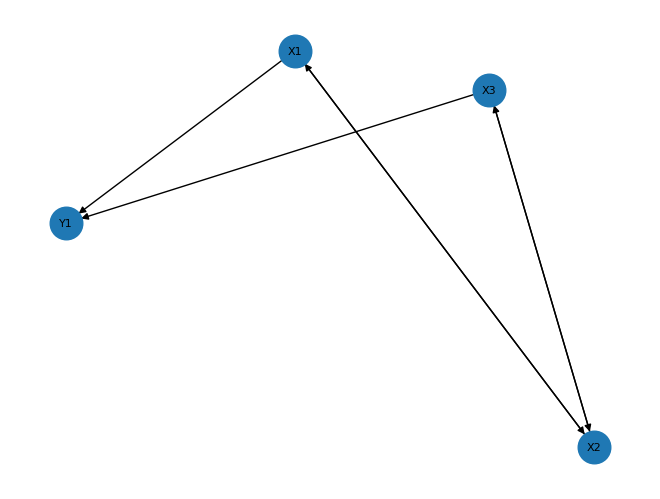

In [10]:
display(df)
causal_graph.display_graph()
print(type(causal_graph.causal_graph))

# Save the time-lagged graph
plt.savefig(f'{DATA_DIR}/{DATA_NAME}.png', format='png', dpi=300, bbox_inches='tight')
print(f'Saved graph to {DATA_DIR}/{DATA_NAME}.png')

plt.show()

# Save the causal graph to a pickled file
with open(f'{DATA_DIR}/{DATA_NAME}-causal_graph.pkl', 'wb') as f:
    pickle.dump(causal_graph.causal_graph, f)
    print(f'Saved pickled causal graph to {DATA_DIR}/{DATA_NAME}-causal_graph.pkl')

summary_graph = causal_graph.generate_summary_graph()
nx.draw(summary_graph, with_labels=True, node_size=550, font_size=8, cmap=plt.get_cmap('Set2'))

# Save the summary graph
plt.savefig(f'{DATA_DIR}/{DATA_NAME}-summary.png', format='png', dpi=300, bbox_inches='tight')
print(f'Saved graph to {DATA_DIR}/{DATA_NAME}-summary_graph.png')
plt.show()

In [13]:
def timeseries_to_timelagged(data_pd, n_lags, window=False):

    '''
    Converts time-series data to time-lagged data
    Parameters
    ----------
        data_pd (pandas dataframe): time-series dataset
                    e.g. V1, V2
        n_lags(int) : number fo previous lags
        window(bool) : True for non-overlapped windows

    Returns
    -------
        data_pd_tl(pandas dataframe) : time-lagged dataset
                    e.g. V1, V2, V1:1, V2:1
    '''

    n_samples = data_pd.shape[0]
    n_nodes = data_pd.shape[1]
    T = n_lags + 1
    var_names = np.empty((1, n_nodes * T), dtype='O')
    data_tl = np.empty((n_samples - n_lags, n_nodes * T), dtype=float)

    for row in range(n_lags, n_samples):
        time_row = np.empty((1, n_nodes * T), dtype='O')
        c = 0
        for t in range(T):
            var_row_minus_t = data_pd.iloc[[row - t]].to_numpy()
            time_row[:, c:c + var_row_minus_t.shape[1]] = var_row_minus_t
            c += var_row_minus_t.shape[1]

        data_tl[row - n_lags, :] = time_row

    # Names
    c = 0
    for t in range(T):
        if t == 0:
            cur_t_name = data_pd.columns
        else:
            cur_t_name = data_pd.columns + ':' + str(t)
        var_names[0, c:c + cur_t_name.shape[0]] = cur_t_name
        c += cur_t_name.shape[0]

    var_names = var_names.reshape(-1, )

    data_pd_tl = pd.DataFrame(data_tl, columns=var_names)

    if window:
        step_ = n_lags + 1
        idx = np.arange(0, data_pd_tl.shape[0], step=step_)
        data_pd_tl = data_pd_tl.iloc[idx, :].reset_index(inplace=False, drop=True)

    return data_pd_tl

### Convert time-series data to time-lagged (cross-sectional with specified window) so that it can be processed by DECI later on

Notice the additional number of features introduced, for $d$ variables and considering a max lag $l$, we now have $d(l+1)$ features 

In [11]:
def timelagged_to_timeseries(data_pd, n_lags):

    '''
    Converts time-lagged data to time-series data
    Parameters
    ----------
        data_pd(pandas dataframe): time-lagged dataset
                e.g. V1, V2, V1:1, V2:1
        n_lags(int) : number fo previous lags

    Returns
    -------
        ts_data(pandas dataframe) : time-series dataset
                e.g. V1, V2
    '''

    T = n_lags + 1
    n_nodes = int(data_pd.shape[1] / T)
    n_rows = data_pd.shape[0] * T
    data_tseries = np.zeros((n_rows, n_nodes), dtype=float)

    for row_lg in range(data_pd.shape[0]):
        for node in range(n_nodes):
            for lag, lag_rv in zip(range(T), reversed(range(T))):
                column_lg = n_nodes * lag_rv + node
                c = T * row_lg + lag
                data_tseries[c, node] = data_pd.iloc[row_lg, column_lg]

    data_tseries_pd = pd.DataFrame(data_tseries, columns = data_pd.columns[0:n_nodes])
    return data_tseries_pd

In [15]:
df_tl = timeseries_to_timelagged(df, max_lag)
display(df_tl)

,X1,X2,X3,Y1,X1:1,X2:1,X3:1,Y1:1
0,0.157786,0.293037,0.105014,0.408150,-0.812489,-0.192600,0.273402,0.387892
1,-0.388606,0.164679,0.006323,0.036488,0.157786,0.293037,0.105014,0.408150
2,-0.342579,-0.214095,-0.387978,0.275473,-0.388606,0.164679,0.006323,0.036488
3,-0.712830,0.339074,-0.117714,-0.015677,-0.342579,-0.214095,-0.387978,0.275473
4,-0.565509,0.211721,0.114700,0.120455,-0.712830,0.339074,-0.117714,-0.015677
...,...,...,...,...,...,...,...,...
994,-0.617760,0.281095,-0.361565,-0.114503,0.383907,0.114923,0.005719,0.429258
995,-0.950191,0.073343,0.178768,0.418774,-0.617760,0.281095,-0.361565,-0.114503
996,-0.512294,0.015122,-0.471763,0.656462,-0.950191,0.073343,0.178768,0.418774
997,-0.754326,0.631936,-0.012310,0.363056,-0.512294,0.015122,-0.471763,0.656462


In [16]:
DATA_DIR = 'datasets'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
df.to_csv(f'{DATA_DIR}/{DATA_NAME}-lagged.csv', index=False)

print(f'Saved dataset to {DATA_DIR}/{DATA_NAME}-lagged.csv')

Saved dataset to datasets/Complexity 30 Num Features 3 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1-lagged.csv


We can now move to the DECI notebook.